In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from tqdm.notebook import tqdm

## Preparation

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

raw_train_set = ImageFolder("img/", transform=transform)
BATCH_SIZE = 128

In [4]:
raw_train_set.class_to_idx

{'00000': 0,
 '00001': 1,
 '00002': 2,
 '00003': 3,
 '00004': 4,
 '00005': 5,
 '00006': 6,
 '00007': 7,
 '00008': 8,
 '00009': 9,
 '00010': 10,
 '00011': 11,
 '00012': 12,
 '00013': 13,
 '00014': 14,
 '00015': 15,
 '00016': 16,
 '00017': 17,
 '00018': 18,
 '00019': 19,
 '00020': 20,
 '00021': 21,
 '00022': 22,
 '00023': 23,
 '00024': 24,
 '00025': 25,
 '00026': 26,
 '00027': 27,
 '00028': 28,
 '00029': 29,
 '00030': 30,
 '00031': 31,
 '00032': 32,
 '00033': 33,
 '00034': 34,
 '00035': 35,
 '00036': 36,
 '00037': 37,
 '00038': 38,
 '00039': 39,
 '00040': 40,
 '00041': 41,
 '00042': 42}

In [5]:
def split_dataset(dataset, test_size, random_state):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=random_state)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)


train_data, test_data = split_dataset(raw_train_set, 0.2, 42)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

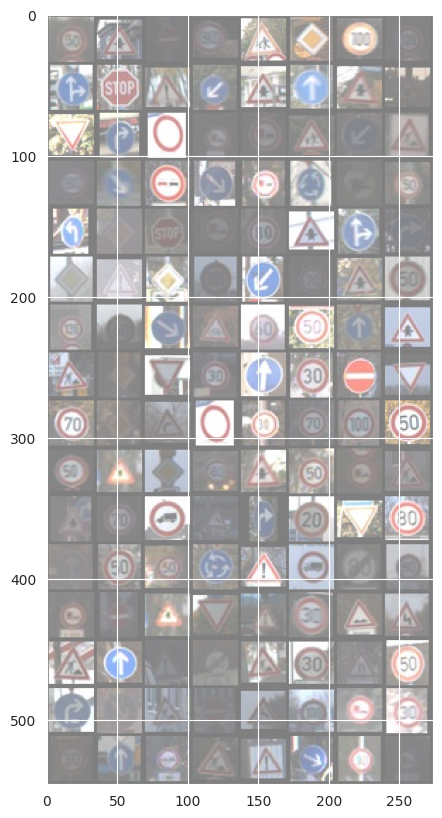

00002 00011 00017 00005 00028 00012 00007 00008 00036 00014 00018 00039 00011 00035 00011 00030 00013 00033 00015 00010 00010 00028 00039 00025 00005 00038 00009 00038 00010 00040 00042 00002 00034 00012 00014 00010 00005 00011 00036 00033 00012 00018 00012 00007 00039 00004 00011 00002 00008 00003 00038 00029 00003 00002 00035 00011 00025 00012 00013 00001 00035 00001 00017 00013 00004 00012 00020 00015 00001 00004 00007 00002 00002 00011 00012 00005 00011 00002 00010 00025 00011 00004 00016 00031 00033 00000 00013 00005 00035 00002 00002 00040 00018 00016 00006 00005 00010 00017 00011 00013 00026 00001 00022 00021 00025 00035 00018 00006 00025 00001 00024 00002 00033 00038 00025 00017 00031 00007 00010 00001 00001 00035 00009 00025 00018 00038 00001 00010


In [6]:
plt.figure(figsize=(20, 10))
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(BATCH_SIZE)))

In [7]:
_, channels, dim1, dim2 = images[0:1].size()
channels, dim1, dim2

(3, 32, 32)

In [9]:
def train(model, optimizer, loss_function=vae_loss_function, num_epochs=30, train_loader=train_loader,
          test_loader=test_loader):
    for n in range(num_epochs):
        losses_epoch = []
        for x, _ in iter(train_loader):
            x = x.to(device)
            out, means, log_var = model(x)
            loss = loss_function(x, out, means, log_var)
            losses_epoch.append(loss.item())
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()
        L1_list = []
        #     if n % 10 == 0:
        for x, _ in iter(test_loader):
            x = x.to(device)
            out, _, _ = model(x)
            L1_list.append(torch.mean(torch.abs(out - x)).item())
        print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
        scheduler.step()

In [10]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    # imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

## Basic VAE

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)  # encoder produces mean and log of variance
        #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, channels, dim1, dim2])
        return x_hat


class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

    def reparameterization(self, mean, var):
        # Change to proper
        epsilon = torch.randn(mean.shape).to(device)
        z = mean + epsilon * var
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [14]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=dim1 * dim2 * channels).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

train(vae, optimizer, vae_loss_function, num_epochs=30)

Epoch 0 loss 15968.344256393308, test L1 = 0.11755659190877792
Epoch 1 loss 10595.413044751174, test L1 = 0.10087932057438358
Epoch 2 loss 9117.033483737852, test L1 = 0.09399928801482724
Epoch 3 loss 8544.343288266562, test L1 = 0.09092961600230585
Epoch 4 loss 8208.250423028217, test L1 = 0.09016585986941092
Epoch 5 loss 7982.763911549638, test L1 = 0.08688486715958964
Epoch 6 loss 7817.903648314437, test L1 = 0.08641735608539274
Epoch 7 loss 7663.888439147453, test L1 = 0.08442335383545968
Epoch 8 loss 7528.643076082555, test L1 = 0.08384826839450867
Epoch 9 loss 7430.382069409378, test L1 = 0.08388700348234945
Epoch 10 loss 7356.054388278868, test L1 = 0.08287861270289268
Epoch 11 loss 7262.43317543588, test L1 = 0.08102703322806666
Epoch 12 loss 7195.980748618521, test L1 = 0.0817551751050257
Epoch 13 loss 7136.975861836255, test L1 = 0.08011089914268063
Epoch 14 loss 7057.234016728595, test L1 = 0.07953501072141432
Epoch 15 loss 7027.552010885099, test L1 = 0.08053789287805557
Ep

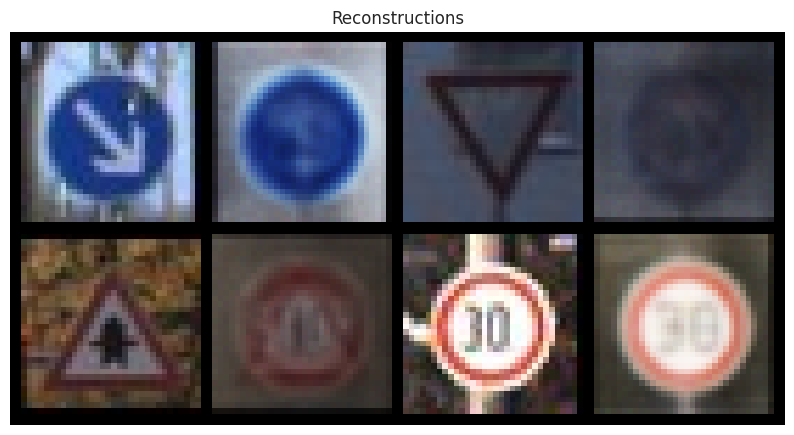

In [12]:
input_imgs, labels = next(iter(test_loader))
input_imgs = input_imgs[:4]
input_imgs.shape
visualize_reconstructions(vae, input_imgs, device)

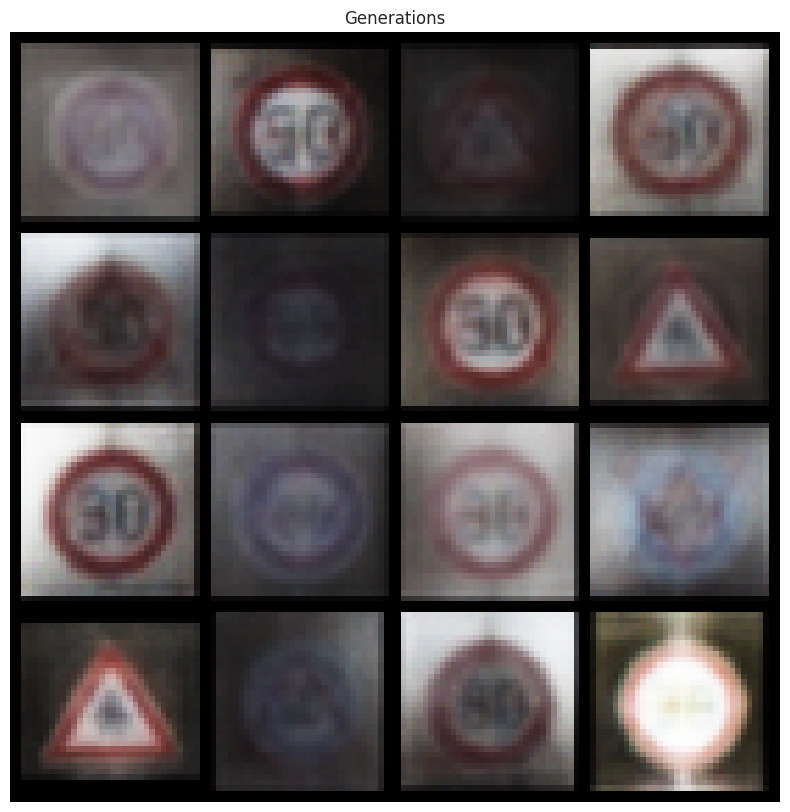

In [13]:
generate_images(vae, 16, device)